In [1]:
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

### Reading data

In [2]:
df=pd.read_csv('hour.csv', sep = ',')

In [3]:
df.head(2)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40


In [4]:
#map season and weather
seasonMap = {1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" }
weatherMap = {1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
              2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
              3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
              4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " }


In [5]:
df["weekday"] = df.dteday.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
df["season"]=df.season.map(seasonMap)
df["weather"]=df.weathersit.map(weatherMap)

In [6]:
df.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,weather
0,1,2011-01-01,Spring,0,1,0,0,Saturday,0,1,0.24,0.2879,0.81,0.0,3,13,16,Clear + Few clouds + Partly cloudy + Partly c...
1,2,2011-01-01,Spring,0,1,1,0,Saturday,0,1,0.22,0.2727,0.80,0.0,8,32,40,Clear + Few clouds + Partly cloudy + Partly c...
2,3,2011-01-01,Spring,0,1,2,0,Saturday,0,1,0.22,0.2727,0.80,0.0,5,27,32,Clear + Few clouds + Partly cloudy + Partly c...


In [7]:
Category=["hr","weekday","mnth","season","weather","holiday","workingday"]
for v in Category:
    df[v]=df[v].astype('category')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 18 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null category
yr            17379 non-null int64
mnth          17379 non-null category
hr            17379 non-null category
holiday       17379 non-null category
weekday       17379 non-null category
workingday    17379 non-null category
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
weather       17379 non-null category
dtypes: category(7), float64(4), int64(6), object(1)
memory usage: 1.6+ MB


In [9]:
df['date']=df['dteday']

### Checking for missing data

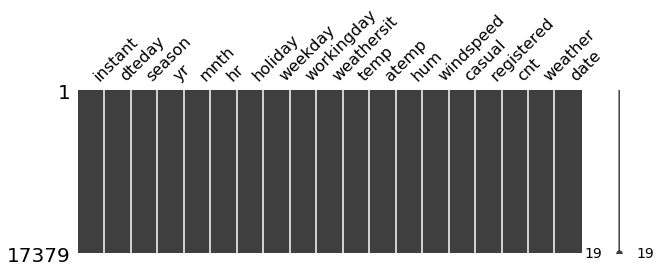

In [10]:
msno.matrix(df,figsize=(10,3))

### Checking outlier

[Text(0,0.5,'Count'),
 Text(0.5,0,'Working Day'),
 Text(0.5,1,'Box Plot On Count/Working Day Distribution')]

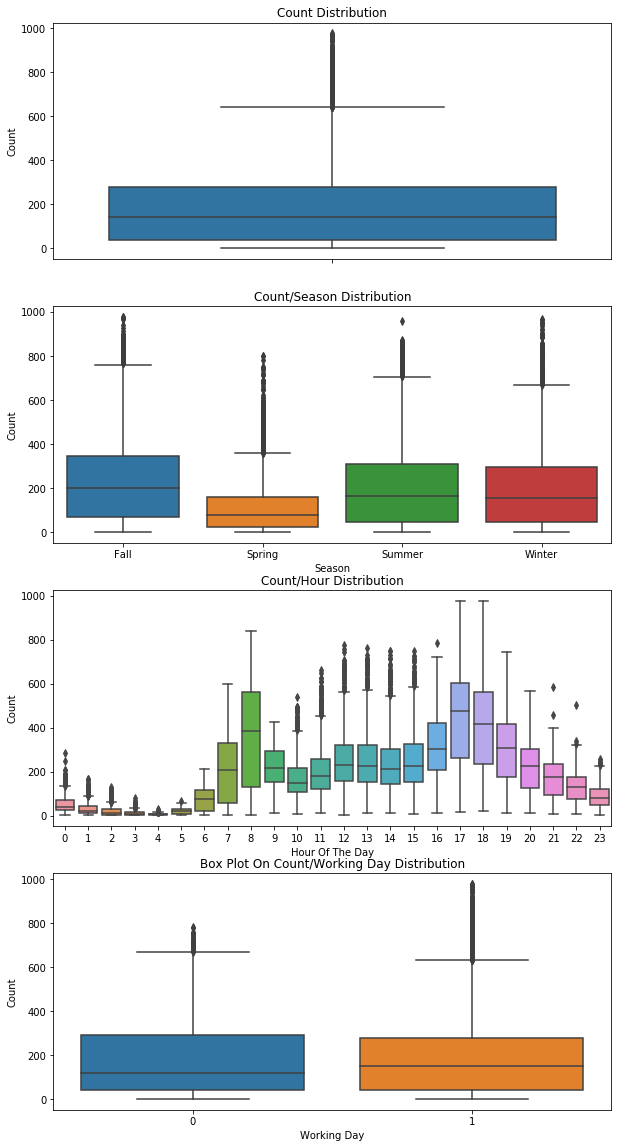

In [12]:
fig,axes=plt.subplots(nrows=4,ncols=1)
fig.set_size_inches(10, 20)
sns.boxplot(data=df,y="cnt",orient="v",ax=axes[0])
sns.boxplot(data=df,y="cnt",x="season",orient="v",ax=axes[1])
sns.boxplot(data=df,y="cnt",x="hr",orient="v",ax=axes[2])
sns.boxplot(data=df,y="cnt",x="workingday",orient="v",ax=axes[3])
axes[0].set(ylabel='Count',title="Count Distribution")
axes[1].set(xlabel='Season', ylabel='Count',title="Count/Season Distribution")
axes[2].set(xlabel='Hour Of The Day', ylabel='Count',title="Count/Hour Distribution")
axes[3].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count/Working Day Distribution")

### Correlation

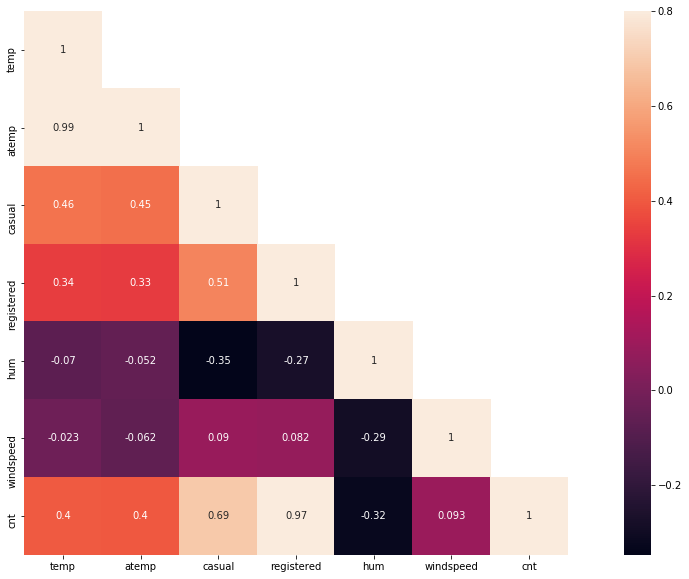

In [13]:
corr=df[["temp","atemp","casual","registered","hum","windspeed","cnt"]].corr()
mask=np.array(corr)
mask[np.tril_indices_from(mask)]=False
fig,axes=plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corr,annot=True,vmax=0.8,mask=mask,square=True)

In [14]:
#Random forest 
# With correlated features, strong features can end up with low scores and the method can be biased towards variables with many categories. 
df=pd.read_csv('hour.csv', sep = ',')
df['date']=df['dteday']
dropFeatures = ['casual',"cnt","date","registered","dteday"]
df=df[pd.notnull(df["cnt"])].sort_values(by='date')
y = df["cnt"]

categoricalFeatureNames = ["season","holiday","workingday","weathersit","weekday","mnth","yr","hr"]
for var in categoricalFeatureNames:
    df[var] = df[var].astype("category")



df  = df.drop(dropFeatures,axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3, random_state=42)

In [15]:
#Create model
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=500)
model.fit(X = X_train,y = np.log1p(y_train))
pred = model.predict(X= X_test)

### Checking errors

In [16]:
# Analyze the results
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

print ("RMSLE Value For Random Forest: ",rmsle(np.exp(np.log1p(y_test)),np.exp(pred),False))

RMSLE Value For Random Forest:  0.2862818419398101


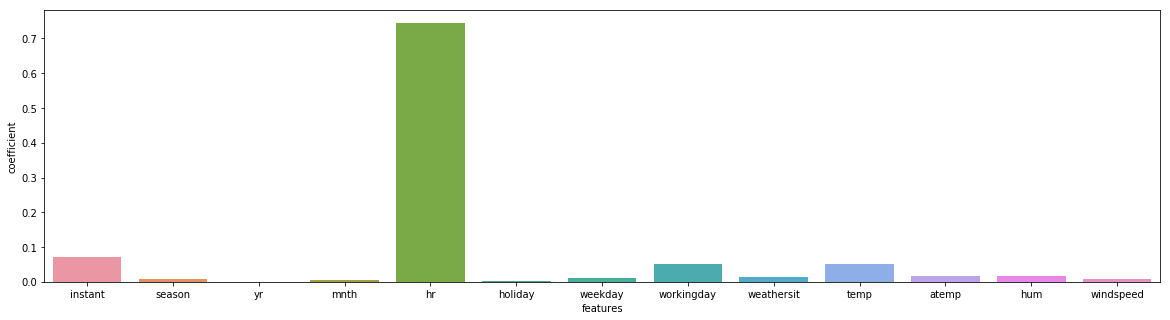

In [17]:
#plot which tree has highest coeefiect
feature=pd.DataFrame()
feature['features']=X_train.columns
feature['coefficient']=model.feature_importances_
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sns.barplot(data=feature,x="features",y="coefficient",ax=ax)